In [1]:
!pip install pmdarima
!pip install arch
!pip install yfinance

     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 727kB 2.8MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=ab5834fe71cdac00fa3f9b3235da9e8ab53386942089ac419da5e8a14a03c5fb
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [0]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest
from arch import arch_model
import yfinance
import warnings; warnings.filterwarnings('ignore')

In [3]:
raw_data = yfinance.download(tickers = "VOW3.DE, PAH3.DE, BMW.DE", 
                             interval='1d', group_by='ticker',
                             auto_adjust=True, treads=True)

[*********************100%***********************]  3 of 3 completed


In [0]:
df = raw_data.copy()

In [0]:
start_date = '2009-04-05'

ann_1 = '2009-12-09'

ann_2 = '2012-07-05'

end_date = '2014-01-01'

d_gate = '2015-09-20'

In [0]:
df['vol'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

df['ret_vol'] = df['vol'].pct_change(1).mul(100)
df['ret_por'] = df['por'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)

df['sq_vol'] = df.ret_vol.mul(df.ret_vol)
df['sq_por'] = df.ret_por.mul(df.ret_por)
df['sq_bmw'] = df.ret_bmw.mul(df.ret_bmw)

df['q_vol'] = df['VOW3.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW.DE'].Volume

In [0]:
df = df.asfreq('b')
df = df.fillna(method='bfill')

In [0]:
del df['VOW3.DE'], df['PAH3.DE'], df['BMW.DE']

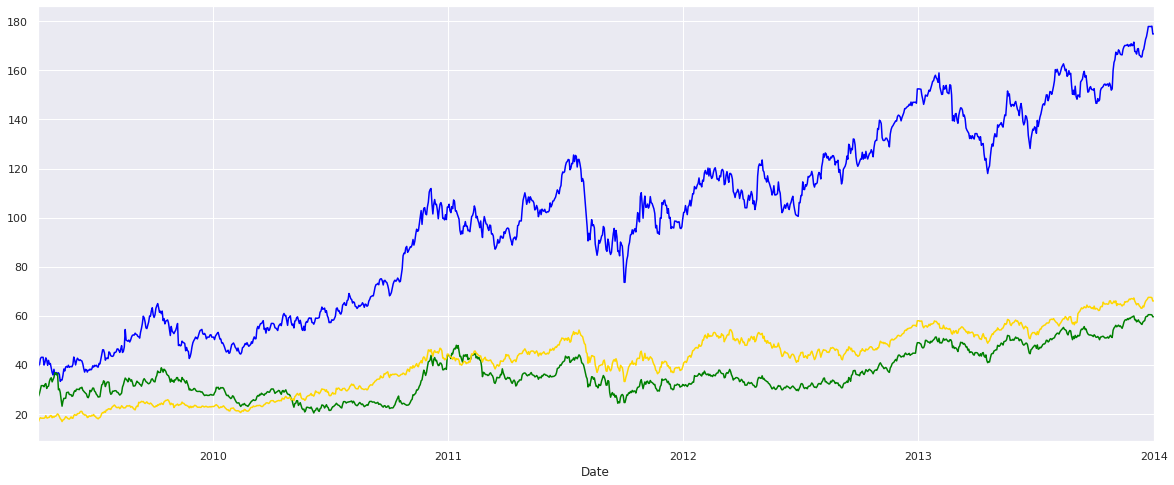

In [9]:
df['vol'][start_date:end_date].plot(figsize=(20,8), color='blue')
df['por'][start_date:end_date].plot(color='green')
df['bmw'][start_date:end_date].plot(color='gold')
plt.show()

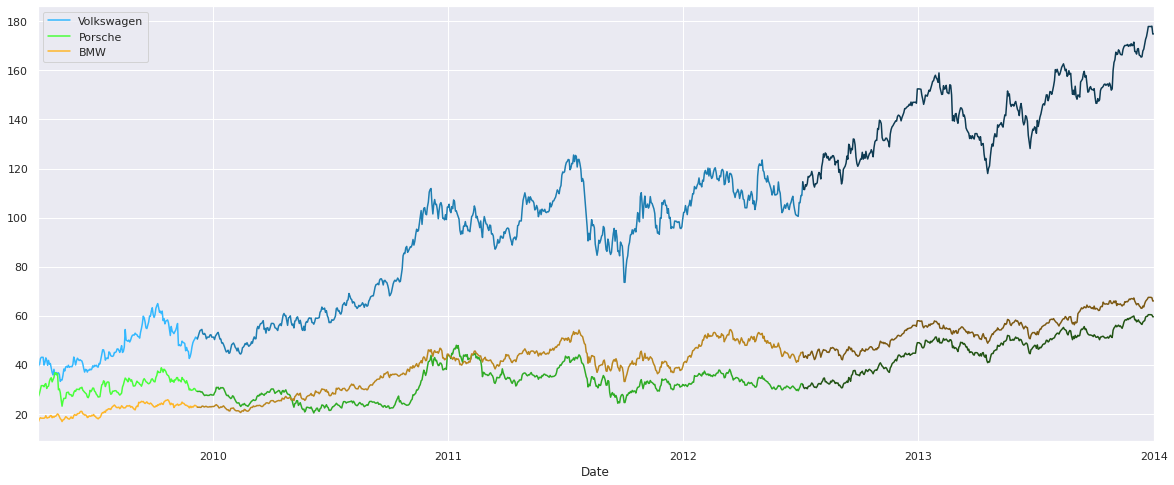

In [10]:
df['vol'][start_date:ann_1].plot(figsize=(20,8), color='#33B8FF')
df['por'][start_date:ann_1].plot(color='#49FF3A')
df['bmw'][start_date:ann_1].plot(color='#FEB628')

df['vol'][ann_1:ann_2].plot(color='#1E7EB2')
df['por'][ann_1:ann_2].plot(color='#2FAB25')
df['bmw'][ann_1:ann_2].plot(color='#BA861F')

df['vol'][ann_2:end_date].plot(color='#0E3A52')
df['por'][ann_2:end_date].plot(color='#225414')
df['bmw'][ann_2:end_date].plot(color='#7C5913')

plt.legend(['Volkswagen', 'Porsche', 'BMW'])
plt.show()

In [11]:
print("Correlation among manufactures from " + str(start_date) + " to " + str(end_date) + '\n')
print("Volkswagen and Porsche Correlation: \t" + str(df['vol'][start_date:end_date].corr(df['por'][start_date:end_date])))
print("Volkswagen and BMW Correlation: \t" + str(df['vol'][start_date:end_date].corr(df['bmw'][start_date:end_date])))
print("Porsche and BMW Correlation: \t\t" + str(df['por'][start_date:end_date].corr(df['bmw'][start_date:end_date])))

Correlation among manufactures from 2009-04-05 to 2014-01-01

Volkswagen and Porsche Correlation: 	0.8348049992443258
Volkswagen and BMW Correlation: 	0.9799384511501867
Porsche and BMW Correlation: 		0.8039398481425047


In [12]:
print("Correlation among manufactures from " + str(start_date) + " to " + str(ann_1) + '\n')
print("Volkswagen and Porsche Correlation: \t" + str(df['vol'][start_date:ann_1].corr(df['por'][start_date:ann_1])))
print("Volkswagen and BMW Correlation: \t" + str(df['vol'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))
print("Porsche and BMW Correlation: \t\t" + str(df['por'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))

Correlation among manufactures from 2009-04-05 to 2009-12-09

Volkswagen and Porsche Correlation: 	0.6633400188255092
Volkswagen and BMW Correlation: 	0.8428353250592515
Porsche and BMW Correlation: 		0.6095045440130231


In [13]:
print("Correlation among manufactures from " + str(ann_1) + " to " + str(ann_2) + '\n')
print("Volkswagen and Porsche Correlation: \t" + str(df['vol'][ann_1:ann_2].corr(df['por'][ann_1:ann_2])))
print("Volkswagen and BMW Correlation: \t" + str(df['vol'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))
print("Porsche and BMW Correlation: \t\t" + str(df['por'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))

Correlation among manufactures from 2009-12-09 to 2012-07-05

Volkswagen and Porsche Correlation: 	0.742211441681872
Volkswagen and BMW Correlation: 	0.9795942983809952
Porsche and BMW Correlation: 		0.7035985466970395


In [14]:
print("Correlation among manufactures from " + str(ann_2) + " to " + str(end_date) + '\n')
print("Volkswagen and Porsche Correlation: \t" + str(df['vol'][ann_2:end_date].corr(df['por'][ann_2:end_date])))
print("Volkswagen and BMW Correlation: \t" + str(df['vol'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))
print("Porsche and BMW Correlation: \t\t" + str(df['por'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))

Correlation among manufactures from 2012-07-05 to 2014-01-01

Volkswagen and Porsche Correlation: 	0.9405236820664735
Volkswagen and BMW Correlation: 	0.9284447102983764
Porsche and BMW Correlation: 		0.9494111676682194


In [15]:
print("Correlation among manufactures from " + str(end_date) + " to " + str(df.index[-1]) + '\n')
print("Volkswagen and Porsche Correlation: \t" + str(df['vol'][end_date:].corr(df['por'][end_date:])))
print("Volkswagen and BMW Correlation: \t" + str(df['vol'][end_date:].corr(df['bmw'][end_date:])))
print("Porsche and BMW Correlation: \t\t" + str(df['por'][end_date:].corr(df['bmw'][end_date:])))

Correlation among manufactures from 2014-01-01 to 2020-03-20 00:00:00

Volkswagen and Porsche Correlation: 	0.9455977154519304
Volkswagen and BMW Correlation: 	0.5164400836219001
Porsche and BMW Correlation: 		0.47500522780269516


In [0]:
mod_pr_pre_vol = auto_arima(df.vol[start_date:ann_1], exogenous=df[["por","bmw"]][start_date:ann_1],
                            m=5, max_p=5, max_q=5)
mod_pr_btn_vol = auto_arima(df.vol[ann_1:ann_2], exogenous=df[["por","bmw"]][ann_1:ann_2],
                            m=5, max_p=5, max_q=5)
mod_pr_post_vol = auto_arima(df.vol[ann_2:end_date], exogenous=df[["por","bmw"]][ann_2:end_date],
                            m=5, max_p=5, max_q=5)

In [17]:
mod_pr_pre_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -329.605
Date:                Sat, 21 Mar 2020   AIC                            669.210
Time:                        00:16:15   BIC                            685.119
Sample:                    04-06-2009   HQIC                           675.661
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7502      0.464      1.618      0.106      -0.159       1.659
por            0.3859      0.093      4.169      0.000       0.205       0.567
bmw            0.6494      0.308      2.108      0.035       0.045       1.253
ar.L1          0.9634      0.020     48.675      0.000       0.925       1.002
sigma2         2.3414      0.159     14.718      0.000       2.030       2.653
===================================================================================
Ljung-Box (Q):                       38.25   Jarque-Bera (JB):               166.09
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                            -0.52
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
mod_pr_btn_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  672
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 5)   Log Likelihood               -1095.725
Date:                           Sat, 21 Mar 2020   AIC                           2207.450
Time:                                   00:16:15   BIC                           2243.520
Sample:                               12-09-2009   HQIC                          2221.420
                                    - 07-05-2012                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0039      0.001      3.490      0.000       0.002       0.006
por            0.7633      0.060     12.828      0.000       0.647       0.880
bmw            1.4605      0.069     21.311      0.000       1.326       1.595
ar.L1          0.9440      0.015     62.654      0.000       0.914       0.974
ma.L1         -0.9995      0.061    -16.427      0.000      -1.119      -0.880
ar.S.L5       -0.9928      0.059    -16.712      0.000      -1.109      -0.876
ma.S.L5        0.9883      0.072     13.680      0.000       0.847       1.130
sigma2         1.5296      0.124     12.349      0.000       1.287       1.772
===================================================================================
Ljung-Box (Q):                       25.72   Jarque-Bera (JB):                90.02
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.67   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
mod_pr_post_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -622.244
Date:                Sat, 21 Mar 2020   AIC                           1250.488
Time:                        00:16:15   BIC                           1262.378
Sample:                    07-05-2012   HQIC                          1255.202
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            1.6623      0.055     30.369      0.000       1.555       1.770
bmw            0.8046      0.086      9.381      0.000       0.637       0.973
sigma2         1.4352      0.070     20.461      0.000       1.298       1.573
===================================================================================
Ljung-Box (Q):                       28.08   Jarque-Bera (JB):               103.80
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.39
Prob(H) (two-sided):                  0.15   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [0]:
mod_pr_pre_por = auto_arima(df.por[start_date:ann_1], exogenous=df[["vol","bmw"]][start_date:ann_1],
                            m=5, max_p=5, max_q=5)
mod_pr_btn_por = auto_arima(df.por[ann_1:ann_2], exogenous=df[["vol","bmw"]][ann_1:ann_2],
                            m=5, max_p=5, max_q=5)
mod_pr_post_por = auto_arima(df.por[ann_2:end_date], exogenous=df[["vol","bmw"]][ann_2:end_date],
                            m=5, max_p=5, max_q=5)

In [21]:
mod_pr_pre_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -238.779
Date:                Sat, 21 Mar 2020   AIC                            489.558
Time:                        00:17:01   BIC                            508.649
Sample:                    04-06-2009   HQIC                           497.300
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6190      0.404      1.533      0.125      -0.173       1.411
vol            0.1192      0.055      2.157      0.031       0.011       0.227
bmw            0.8576      0.154      5.557      0.000       0.555       1.160
ar.L1          1.0747      0.059     18.194      0.000       0.959       1.191
ar.L2         -0.1589      0.059     -2.716      0.007      -0.274      -0.044
sigma2         0.8468      0.060     14.098      0.000       0.729       0.964
===================================================================================
Ljung-Box (Q):                       26.01   Jarque-Bera (JB):               559.45
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
mod_pr_btn_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -629.007
Date:                Sat, 21 Mar 2020   AIC                           1268.013
Time:                        00:17:01   BIC                           1290.557
Sample:                    12-09-2009   HQIC                          1276.745
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0226      0.024     -0.938      0.348      -0.070       0.025
vol            0.1867      0.017     11.219      0.000       0.154       0.219
bmw            0.3148      0.045      7.022      0.000       0.227       0.403
ar.L1          0.0712      0.030      2.343      0.019       0.012       0.131
sigma2         0.3817      0.012     32.515      0.000       0.359       0.405
===================================================================================
Ljung-Box (Q):                       35.66   Jarque-Bera (JB):              1072.22
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             0.07
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
mod_pr_post_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  390
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 5)   Log Likelihood                -236.012
Date:                           Sat, 21 Mar 2020   AIC                            484.023
Time:                                   00:17:07   BIC                            507.805
Sample:                               07-05-2012   HQIC                           493.451
                                    - 01-01-2014                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0228      0.020      1.162      0.245      -0.016       0.061
vol            0.2302      0.014     16.410      0.000       0.203       0.258
bmw            0.2407      0.041      5.857      0.000       0.160       0.321
ma.L1         -0.0762      0.056     -1.373      0.170      -0.185       0.033
ma.S.L5       -0.1355      0.058     -2.337      0.019      -0.249      -0.022
sigma2         0.1970      0.008     25.906      0.000       0.182       0.212
===================================================================================
Ljung-Box (Q):                       33.69   Jarque-Bera (JB):               612.83
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

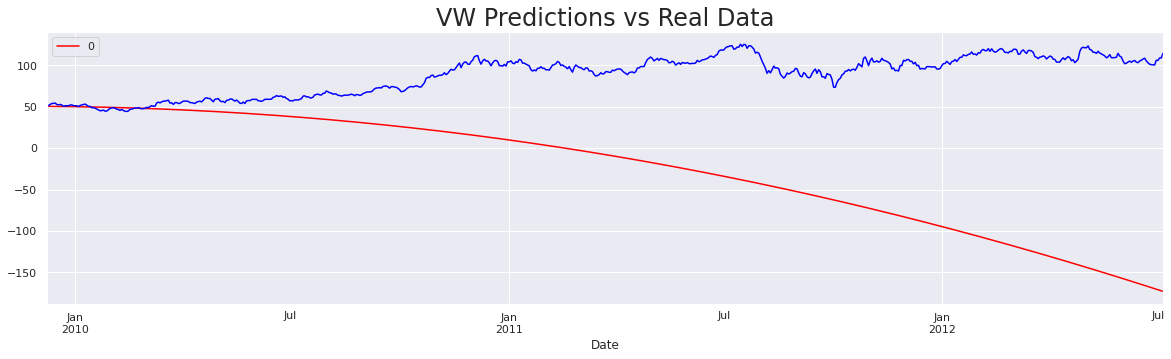

In [24]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], m=5, max_p=5, max_q=5, max_P=5, max_Q=5, trend='ct')

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods=len(df[ann_1:ann_2])), index=df[ann_1:ann_2].index)

df_auto_pred_pr[ann_1:ann_2].plot(figsize=(20, 5), color='red')
df.vol[ann_1:ann_2].plot(color='blue')
plt.title("VW Predictions vs Real Data", size=24)
plt.show()

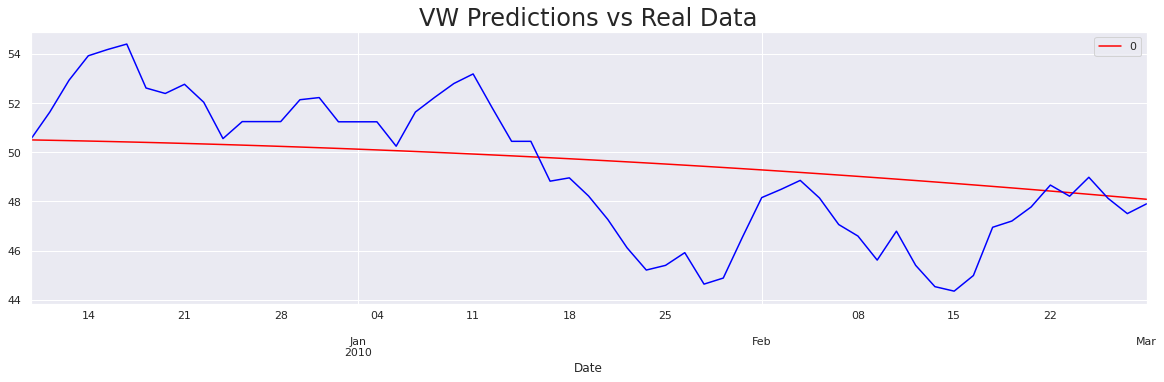

In [25]:
df_auto_pred_pr[ann_1:'2010-03-01'].plot(figsize=(20,5), color='red')
df.vol[ann_1:'2010-03-01'].plot(color='blue')
plt.title('VW Predictions vs Real Data', size=24)
plt.show()

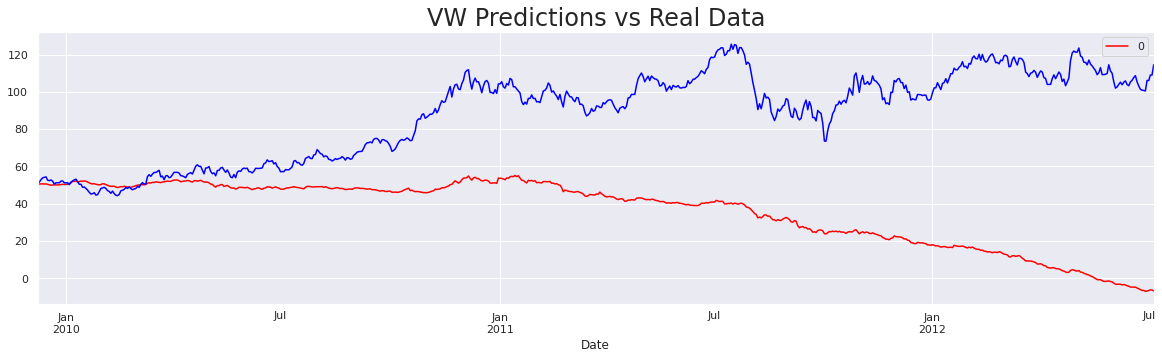

In [28]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous=df[['por']][start_date:ann_1], m=5, max_p=5, max_q=5, max_P=5, max_Q=5, trend='ct')

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods=len(df[ann_1:ann_2]), exogenous=df[['por']][ann_1:ann_2]), index=df[ann_1:ann_2].index)

df_auto_pred_pr[ann_1:ann_2].plot(figsize=(20, 5), color='red')
df.vol[ann_1:ann_2].plot(color='blue')
plt.title("VW Predictions vs Real Data", size=24)
plt.show()

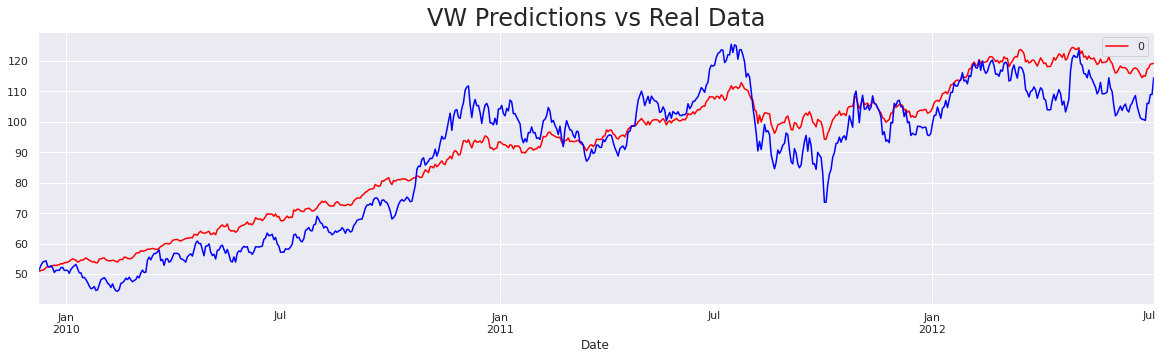

In [29]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous=df[['bmw']][start_date:ann_1], m=5, max_p=5, max_q=5, max_P=5, max_Q=5, trend='ct')

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods=len(df[ann_1:ann_2]), exogenous=df[['bmw']][ann_1:ann_2]), index=df[ann_1:ann_2].index)

df_auto_pred_pr[ann_1:ann_2].plot(figsize=(20, 5), color='red')
df.vol[ann_1:ann_2].plot(color='blue')
plt.title("VW Predictions vs Real Data", size=24)
plt.show()

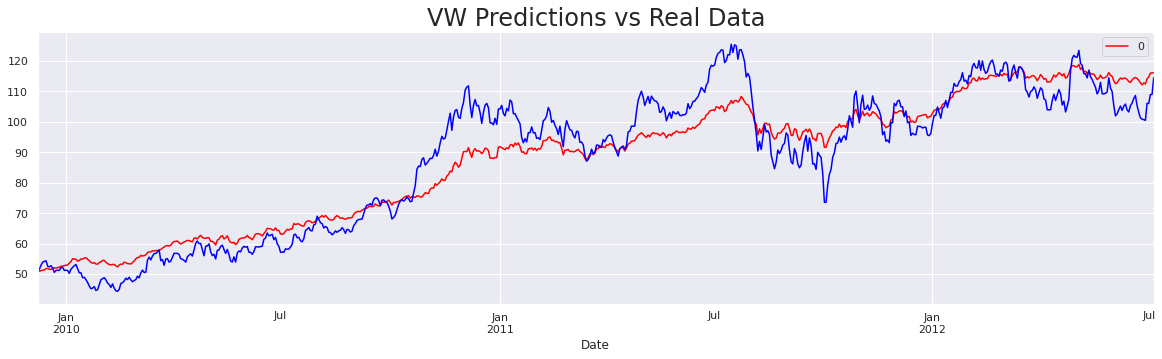

In [30]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous=df[['por','bmw']][start_date:ann_1], m=5, max_p=5, max_q=5, max_P=5, max_Q=5, trend='ct')

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods=len(df[ann_1:ann_2]), exogenous=df[['por','bmw']][ann_1:ann_2]), index=df[ann_1:ann_2].index)

df_auto_pred_pr[ann_1:ann_2].plot(figsize=(20, 5), color='red')
df.vol[ann_1:ann_2].plot(color='blue')
plt.title("VW Predictions vs Real Data", size=24)
plt.show()

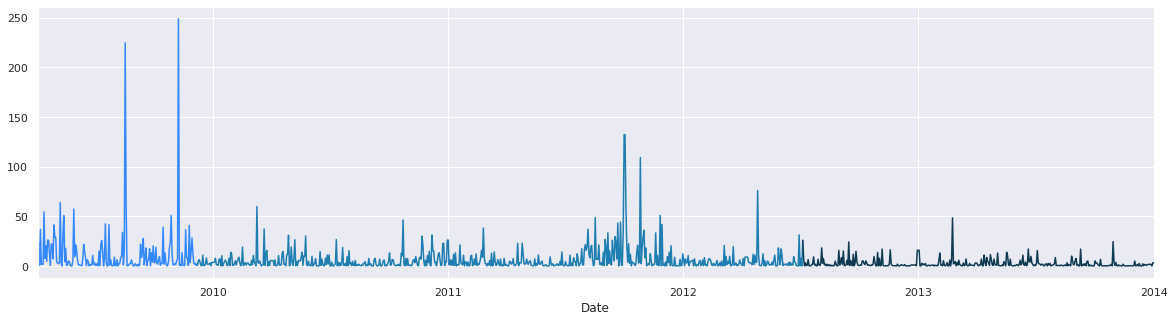

In [31]:
df['sq_vol'][start_date:ann_1].plot(figsize=(20,5), color='#3388FF')
df['sq_vol'][ann_1:ann_2].plot(color='#1E7EB2')
df['sq_vol'][ann_2:end_date].plot(color='#0E3A52')
plt.show()

In [32]:
model_garch_pre = arch_model(df.ret_vol[start_date:ann_1], mean='Constant', vol='GARCH', p=1, q=1)
results_garch_pre = model_garch_pre.fit(update_freq=5)

model_garch_btn = arch_model(df.ret_vol[ann_1:ann_2], mean='Constant', vol='GARCH', p=1, q=1)
results_garch_btn = model_garch_btn.fit(update_freq=5)

model_garch_post = arch_model(df.ret_vol[ann_2:end_date], mean='Constant', vol='GARCH', p=1, q=1)
results_garch_post = model_garch_post.fit(update_freq=5)

Iteration:      5,   Func. Count:     35,   Neg. LLF: 475.8106472182344
Iteration:     10,   Func. Count:     65,   Neg. LLF: 475.03031772801364
Iteration:     15,   Func. Count:     95,   Neg. LLF: 474.9915210237318
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 474.9915209714288
            Iterations: 15
            Function evaluations: 95
            Gradient evaluations: 15
Iteration:      5,   Func. Count:     42,   Neg. LLF: 1526.9228402592855
Iteration:     10,   Func. Count:     72,   Neg. LLF: 1526.7316954368202
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1526.731695435576
            Iterations: 10
            Function evaluations: 72
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     38,   Neg. LLF: 724.56203649128
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 724.5578157322791
            Iterations: 7
            

In [33]:
results_garch_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -474.992
Distribution:                  Normal   AIC:                           957.983
Method:            Maximum Likelihood   BIC:                           970.710
                                        No. Observations:                  178
Date:                Sat, Mar 21 2020   Df Residuals:                      174
Time:                        00:37:12   Df Model:                            4
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1571      0.266      0.590      0.556 [ -0.365,  0.679]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         10.6195      4.227      2.512  1.200e-02    [  2.334, 18.905]
alpha[1]       0.1540  9.197e-02      1.675  9.401e-02 [-2.624e-02,  0.334]
beta[1]        0.0000      0.349      0.000      1.000    [ -0.684,  0.684]
===========================================================================

Covariance estimator: robust
"""

In [34]:
results_garch_btn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -1526.73
Distribution:                  Normal   AIC:                           3061.46
Method:            Maximum Likelihood   BIC:                           3079.50
                                        No. Observations:                  672
Date:                Sat, Mar 21 2020   Df Residuals:                      668
Time:                        00:37:12   Df Model:                            4
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1892  8.634e-02      2.191  2.843e-02 [1.998e-02,  0.358]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1679  7.914e-02      2.122  3.388e-02 [1.279e-02,  0.323]
alpha[1]       0.0688  1.682e-02      4.091  4.301e-05 [3.585e-02,  0.102]
beta[1]        0.9040  2.108e-02     42.883      0.000   [  0.863,  0.945]
==========================================================================

Covariance estimator: robust
"""

In [35]:
results_garch_post.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -724.558
Distribution:                  Normal   AIC:                           1457.12
Method:            Maximum Likelihood   BIC:                           1472.98
                                        No. Observations:                  390
Date:                Sat, Mar 21 2020   Df Residuals:                      386
Time:                        00:37:12   Df Model:                            4
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2298  9.845e-02      2.334  1.958e-02 [3.685e-02,  0.423]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.7719      0.677      1.141      0.254    [ -0.554,  2.098]
alpha[1]       0.1853      0.145      1.273      0.203 [-9.991e-02,  0.470]
beta[1]        0.5136      0.331      1.550      0.121    [ -0.136,  1.163]
===========================================================================

Covariance estimator: robust
"""